# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import statsmodels.api as sm
import time

In [3]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Open and arrange the data

## Liquidity data

In [5]:
# liq_df = pd.read_excel('Net_Liquidity.xls', index_col='Date')
# liq_df = pd.read_excel('Net_Liquidity_6_24.xls', index_col='Date')
liq_df = pd.read_excel('Net_Liquidity_8_24.xls', index_col='Date')
liq_df.head(10)

,Balance_sheet,Reverse_repo,Treasury_general_account
Date,,,
2024-08-28,7123238.0,388.890,786228.0
2024-08-21,7139952.0,321.329,758980.0
2024-08-14,7177688.0,328.472,812614.0
2024-08-07,7175256.0,286.660,779820.0
2024-07-31,7178391.0,413.200,802422.0
2024-07-24,7205455.0,399.121,793467.0
2024-07-17,7208247.0,399.401,795024.0
2024-07-10,7224079.0,422.147,747238.0
2024-07-03,7221520.0,425.898,745608.0


In [6]:
# From billions to millions
liq_df['Reverse_repo'] = liq_df['Reverse_repo'] * 1000

In [7]:
liq_df['Net_liquidity'] = liq_df['Balance_sheet']-liq_df['Reverse_repo']-liq_df['Treasury_general_account']

<Axes: xlabel='Date'>

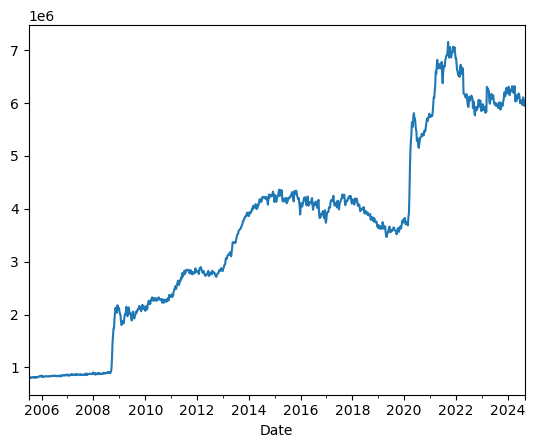

In [8]:
liq_df['Net_liquidity'][:1000].plot()

In [9]:
# get rid of the not full month
liq_df = liq_df[1:]

In [10]:
# get rid of the extra rows

In [11]:
liq_df['Date'] = pd.to_datetime(liq_df.index)

In [12]:
filtered_data = liq_df.groupby(liq_df['Date'].dt.to_period("M")).apply(lambda x: x.loc[x['Date'].idxmax()])

In [13]:
filtered_data

,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity,Date
Date,,,,,
1914-11,270.018,0.0,NaN,NaN,1914-11-27
1914-12,277.844,0.0,NaN,NaN,1914-12-31
1915-01,302.234,0.0,NaN,NaN,1915-01-29
1915-02,331.733,0.0,NaN,NaN,1915-02-26
1915-03,333.211,0.0,NaN,NaN,1915-03-26
...,...,...,...,...,...
2024-04,7402434.000,441215.0,929379.0,6031840.0,2024-04-24
2024-05,7284319.000,459314.0,716020.0,6108985.0,2024-05-29
2024-06,7231163.000,490156.0,744206.0,5996801.0,2024-06-26


In [14]:
# Set the day of the 'Date' column to the last day of the month
filtered_data['date'] = filtered_data['Date'] + pd.offsets.BMonthEnd(0)
filtered_data.drop('Date', axis=1, inplace=True)

In [15]:
type(filtered_data['date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
filtered_data

,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity,date
Date,,,,,
1914-11,270.018,0.0,NaN,NaN,1914-11-30
1914-12,277.844,0.0,NaN,NaN,1914-12-31
1915-01,302.234,0.0,NaN,NaN,1915-01-29
1915-02,331.733,0.0,NaN,NaN,1915-02-26
1915-03,333.211,0.0,NaN,NaN,1915-03-31
...,...,...,...,...,...
2024-04,7402434.000,441215.0,929379.0,6031840.0,2024-04-30
2024-05,7284319.000,459314.0,716020.0,6108985.0,2024-05-31
2024-06,7231163.000,490156.0,744206.0,5996801.0,2024-06-28


In [17]:
filtered_data.reset_index(inplace=True)
filtered_data.set_index('date', inplace=True)

In [18]:
# filtered_data.drop('Date', axis=1, inplace=True)

## Main data

In [19]:
# df = pd.read_csv('data_2024.csv')
# df = pd.read_csv('data_4_24.csv')
# df = pd.read_csv('data_6_24.csv')
df = pd.read_csv('data_8_24.csv', encoding='latin-1')
df

,date,PE_RATIO,EST_PE_NEXT_YR_AGGTE,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,S&P 500 FORWARD 1 YEAR GAIN,àéðôìöéä 1Y éãåòä,GENERIC INFLATION INDEXED 5Y GOV BOND,EXPECTED INFLATION 5Y
0,31/08/2024,25.7022,20.3690,3.7027,4.4023,12344.43,3.890718,4.909421,1.206721,27.135292,NaN,2.9,1.695,1.974237
1,31/07/2024,25.7642,19.9031,3.9132,4.7447,12052.09,3.881355,5.024343,1.111143,22.148282,NaN,2.9,1.786,2.089875
2,30/06/2024,25.5832,19.6815,4.3765,5.1100,11907.15,3.908815,5.080914,0.704414,24.556078,NaN,3.0,2.112,2.217663
3,31/05/2024,24.6895,19.1033,4.5070,5.1754,11494.70,4.050305,5.234698,0.727698,28.186628,NaN,3.4,2.166,2.291369
4,30/04/2024,24.0738,18.2660,4.7154,5.2354,10951.66,4.153893,5.474652,0.759252,22.661634,NaN,3.5,2.292,2.369100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,31/05/1990,15.4024,11.8938,8.5490,8.2230,393.80,6.492495,8.407742,-0.141258,NaN,11.792788,4.4,NaN,NaN
412,30/04/1990,14.1063,10.8548,9.0000,8.5350,358.81,7.089031,9.212514,0.212514,NaN,17.619353,4.7,NaN,NaN
413,30/03/1990,14.4666,11.0969,8.6380,8.3310,368.00,6.912474,9.011526,0.373526,NaN,14.410326,5.2,NaN,NaN
414,28/02/1990,13.9688,10.7204,8.4510,8.1090,358.50,7.158811,9.328010,0.877010,NaN,14.666667,5.3,NaN,NaN


In [20]:
# rename column
df.rename(columns={'אינפלציה 1Y ידועה':'Known_inflation_1Y'}, inplace=True)
df.rename(columns={'EST_PE_NEXT_YR_AGGTE':'Fut_PE_Ratio'}, inplace=True)

## Join

In [21]:
type(df['date'].iloc[0])

str

In [22]:
df['date'] = pd.to_datetime(df['date'])
type(df['date'].iloc[0])

/var/folders/s7/8_j4bgj967g5l_x97vbsfvwr0000gn/T/ipykernel_5989/2286941840.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


pandas._libs.tslibs.timestamps.Timestamp

In [23]:
df.set_index('date', inplace=True)
df

,PE_RATIO,Fut_PE_Ratio,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,S&P 500 FORWARD 1 YEAR GAIN,àéðôìöéä 1Y éãåòä,GENERIC INFLATION INDEXED 5Y GOV BOND,EXPECTED INFLATION 5Y
date,,,,,,,,,,,,,
2024-08-31,25.7022,20.3690,3.7027,4.4023,12344.43,3.890718,4.909421,1.206721,27.135292,NaN,2.9,1.695,1.974237
2024-07-31,25.7642,19.9031,3.9132,4.7447,12052.09,3.881355,5.024343,1.111143,22.148282,NaN,2.9,1.786,2.089875
2024-06-30,25.5832,19.6815,4.3765,5.1100,11907.15,3.908815,5.080914,0.704414,24.556078,NaN,3.0,2.112,2.217663
2024-05-31,24.6895,19.1033,4.5070,5.1754,11494.70,4.050305,5.234698,0.727698,28.186628,NaN,3.4,2.166,2.291369
2024-04-30,24.0738,18.2660,4.7154,5.2354,10951.66,4.153893,5.474652,0.759252,22.661634,NaN,3.5,2.292,2.369100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-05-31,15.4024,11.8938,8.5490,8.2230,393.80,6.492495,8.407742,-0.141258,NaN,11.792788,4.4,NaN,NaN
1990-04-30,14.1063,10.8548,9.0000,8.5350,358.81,7.089031,9.212514,0.212514,NaN,17.619353,4.7,NaN,NaN
1990-03-30,14.4666,11.0969,8.6380,8.3310,368.00,6.912474,9.011526,0.373526,NaN,14.410326,5.2,NaN,NaN


In [24]:
len(df)

416

In [25]:
df = pd.merge(df, filtered_data, left_index=True, right_index=True)

In [26]:
df

,PE_RATIO,Fut_PE_Ratio,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,S&P 500 FORWARD 1 YEAR GAIN,àéðôìöéä 1Y éãåòä,GENERIC INFLATION INDEXED 5Y GOV BOND,EXPECTED INFLATION 5Y,Date,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity
date,,,,,,,,,,,,,,,,,,
2024-07-31,25.7642,19.9031,3.9132,4.7447,12052.09,3.881355,5.024343,1.111143,22.148282,NaN,2.9,1.786,2.089875,2024-07,7178391.0,413200.0,802422.0,5962769.0
2024-05-31,24.6895,19.1033,4.5070,5.1754,11494.70,4.050305,5.234698,0.727698,28.186628,NaN,3.4,2.166,2.291369,2024-05,7284319.0,459314.0,716020.0,6108985.0
2024-04-30,24.0738,18.2660,4.7154,5.2354,10951.66,4.153893,5.474652,0.759252,22.661634,NaN,3.5,2.292,2.369100,2024-04,7402434.0,441215.0,929379.0,6031840.0
2024-02-29,24.3555,18.7146,4.2447,4.9981,11062.11,4.105849,5.343422,1.098722,30.452487,NaN,3.1,1.846,2.355223,2024-02,7567807.0,569855.0,767672.0,6230280.0
2024-01-31,23.3100,20.0589,3.8354,4.7069,10501.38,4.290004,4.985318,1.149918,20.818281,NaN,3.1,1.593,2.207239,2024-01,7630124.0,615379.0,865481.0,6149264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-05-31,15.4024,11.8938,8.5490,8.2230,393.80,6.492495,8.407742,-0.141258,NaN,11.792788,4.4,NaN,NaN,1990-05,300256.0,0.0,4420.0,295836.0
1990-04-30,14.1063,10.8548,9.0000,8.5350,358.81,7.089031,9.212514,0.212514,NaN,17.619353,4.7,NaN,NaN,1990-04,297447.0,0.0,4125.0,293322.0
1990-03-30,14.4666,11.0969,8.6380,8.3310,368.00,6.912474,9.011526,0.373526,NaN,14.410326,5.2,NaN,NaN,1990-03,294961.0,0.0,6218.0,288743.0


In [27]:
len(df)

413

In [28]:
df.reset_index(inplace=True)
df

,date,PE_RATIO,Fut_PE_Ratio,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,S&P 500 FORWARD 1 YEAR GAIN,àéðôìöéä 1Y éãåòä,GENERIC INFLATION INDEXED 5Y GOV BOND,EXPECTED INFLATION 5Y,Date,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity
0,2024-07-31,25.7642,19.9031,3.9132,4.7447,12052.09,3.881355,5.024343,1.111143,22.148282,NaN,2.9,1.786,2.089875,2024-07,7178391.0,413200.0,802422.0,5962769.0
1,2024-05-31,24.6895,19.1033,4.5070,5.1754,11494.70,4.050305,5.234698,0.727698,28.186628,NaN,3.4,2.166,2.291369,2024-05,7284319.0,459314.0,716020.0,6108985.0
2,2024-04-30,24.0738,18.2660,4.7154,5.2354,10951.66,4.153893,5.474652,0.759252,22.661634,NaN,3.5,2.292,2.369100,2024-04,7402434.0,441215.0,929379.0,6031840.0
3,2024-02-29,24.3555,18.7146,4.2447,4.9981,11062.11,4.105849,5.343422,1.098722,30.452487,NaN,3.1,1.846,2.355223,2024-02,7567807.0,569855.0,767672.0,6230280.0
4,2024-01-31,23.3100,20.0589,3.8354,4.7069,10501.38,4.290004,4.985318,1.149918,20.818281,NaN,3.1,1.593,2.207239,2024-01,7630124.0,615379.0,865481.0,6149264.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1990-05-31,15.4024,11.8938,8.5490,8.2230,393.80,6.492495,8.407742,-0.141258,NaN,11.792788,4.4,NaN,NaN,1990-05,300256.0,0.0,4420.0,295836.0
409,1990-04-30,14.1063,10.8548,9.0000,8.5350,358.81,7.089031,9.212514,0.212514,NaN,17.619353,4.7,NaN,NaN,1990-04,297447.0,0.0,4125.0,293322.0
410,1990-03-30,14.4666,11.0969,8.6380,8.3310,368.00,6.912474,9.011526,0.373526,NaN,14.410326,5.2,NaN,NaN,1990-03,294961.0,0.0,6218.0,288743.0
411,1990-02-28,13.9688,10.7204,8.4510,8.1090,358.50,7.158811,9.328010,0.877010,NaN,14.666667,5.3,NaN,NaN,1990-02,291668.0,0.0,6613.0,285055.0


In [29]:
df.sort_index(ascending=False, inplace=True)
df.head(2)

,date,PE_RATIO,Fut_PE_Ratio,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,S&P 500 FORWARD 1 YEAR GAIN,àéðôìöéä 1Y éãåòä,GENERIC INFLATION INDEXED 5Y GOV BOND,EXPECTED INFLATION 5Y,Date,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity
412,1990-01-31,13.7883,10.5891,8.318,8.075,353.94,7.252526,9.443673,1.125673,NaN,8.391253,5.2,NaN,NaN,1990-01,292033.0,0.0,13153.0,278880.0
411,1990-02-28,13.9688,10.7204,8.451,8.109,358.50,7.158811,9.328010,0.877010,NaN,14.666667,5.3,NaN,NaN,1990-02,291668.0,0.0,6613.0,285055.0


<Axes: xlabel='Date'>

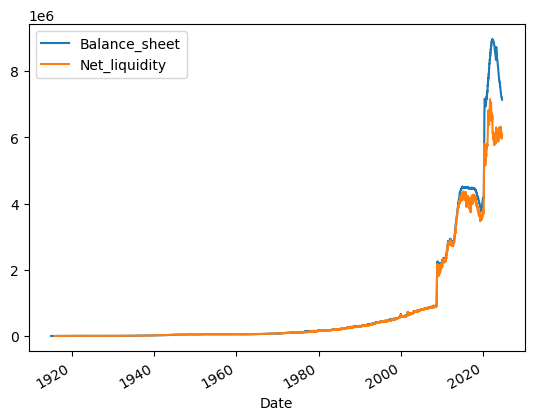

In [30]:
liq_df[['Balance_sheet', 'Net_liquidity']].plot()

# Parameters

In [31]:
days_for_test = 48
target = 'S&P 500 FORWARD 1 YEAR GAIN'
rsi_period = 10

# The yearly forward change in S&P 500 for classification (in %)
increase = 0

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500, num = 20)]
# n_estimators = [int(x) for x in np.linspace(start = 5, stop = 10, num = 1)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = list(range(10)[1:])
# Minimum number of samples required at each leaf node
min_samples_leaf = list(range(10)[1:])
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Features ingeneering

## RSI

In [32]:
def calc_rsi_two(df, col, rsi_period = 14):
    series = df[col]
    series = series[col].sort_values(col[0])
    series = df[col[1]]
    chg = series.diff(1)
    gain = chg.mask(chg<0,0)
    loss = chg.mask(chg>0,0)
    avg_gain = gain.ewm(com = rsi_period-1,min_periods=rsi_period).mean()
    avg_loss = loss.ewm(com = rsi_period-1,min_periods=rsi_period).mean()
    rs = abs(avg_gain / avg_loss)
    rsi = 1 - (1/(1+rs))
    rsi[:rsi_period] = 0.5
    return rsi

In [33]:
df['Balance_sheet_RSI'] = calc_rsi_two(df, ['date', 'Balance_sheet'], rsi_period = rsi_period)

In [34]:
df['Net_liquidity_RSI'] = calc_rsi_two(df, ['date', 'Net_liquidity'], rsi_period = rsi_period)

<Axes: xlabel='date'>

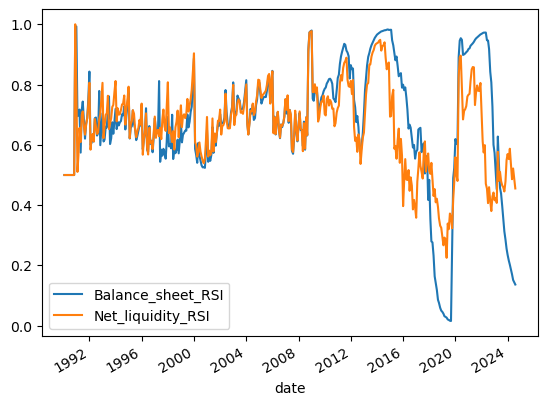

In [35]:
df.set_index('date')[['Balance_sheet_RSI', 'Net_liquidity_RSI']].plot()

## Percentage change

<Axes: >

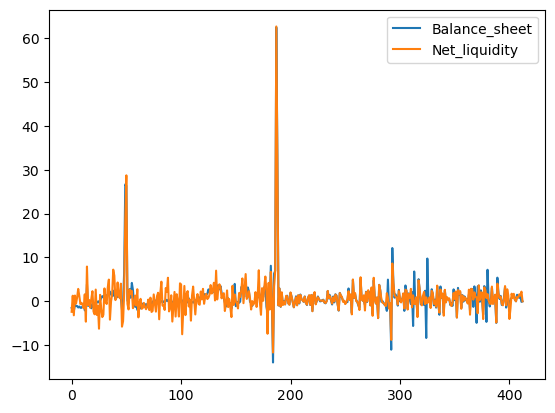

In [36]:
pct = df[['Balance_sheet', 'Net_liquidity']].pct_change()
pct.iloc[0] = 0
pct *= 100
pct.plot()

In [37]:
df['Balance_sheet_%'] = pct['Balance_sheet']
df['Net_liquidity_%'] = pct['Net_liquidity']

## Mooving Average

In [38]:
ma = 3

In [39]:
df['Balance_sheet_%_MA'] = df['Balance_sheet_%'].rolling(window=ma).mean()

In [40]:
df['Net_liquidity_%_MA'] = df['Net_liquidity_%'].rolling(window=ma).mean()

# Data Arrangments

In [41]:
this_month = df[-1:]
this_year = df[-12:]
this_year

,date,PE_RATIO,Fut_PE_Ratio,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,...,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity,Balance_sheet_RSI,Net_liquidity_RSI,Balance_sheet_%,Net_liquidity_%,Balance_sheet_%_MA,Net_liquidity_%_MA
11,2023-06-30,21.3668,18.4360,4.1556,5.3922,9559.67,4.680158,5.424170,1.268570,19.594092,...,8340914.0,1945211.0,408561.0,5987142.0,0.437913,0.479761,-0.535902,-1.567468,-1.415514,-1.537584
10,2023-07-31,22.0325,18.9588,4.1774,5.3779,9866.77,4.538750,5.274595,1.097195,13.015465,...,8243344.0,1749733.0,549897.0,5943714.0,0.397254,0.465658,-1.169776,-0.725354,-1.257254,-0.232650
9,2023-08-31,22.0812,18.3675,4.2541,5.3844,9709.68,4.528739,5.444399,1.190299,15.944507,...,8121316.0,1696819.0,500702.0,5923795.0,0.351857,0.458785,-1.480322,-0.335127,-1.062000,-0.875983
8,2023-09-29,21.0015,17.4623,4.6090,5.4484,9246.74,4.761565,5.726622,1.117622,21.617384,...,8002064.0,1442805.0,672142.0,5887117.0,0.313016,0.445337,-1.468383,-0.619164,-1.372827,-0.559882
7,2023-10-31,20.5399,17.1677,4.8536,5.4500,9052.31,4.868573,5.824892,0.971292,10.142845,...,7907830.0,1100617.0,847717.0,5959496.0,0.285358,0.478833,-1.177621,1.229447,-1.375442,0.091719
6,2023-11-30,21.9210,18.7221,4.2663,5.1172,9879.02,4.561836,5.341281,1.074981,13.839825,...,7796145.0,914187.0,753570.0,6128388.0,0.255615,0.549387,-1.412334,2.833998,-1.352779,1.148094
5,2023-12-29,22.9453,19.6081,3.8471,4.7622,10327.83,4.358191,5.099933,1.252833,26.287659,...,7712781.0,818869.0,713064.0,6180848.0,0.235277,0.569501,-1.069298,0.856016,-1.219751,1.639821
4,2024-01-31,23.3100,20.0589,3.8354,4.7069,10501.38,4.290004,4.985318,1.149918,20.818281,...,7630124.0,615379.0,865481.0,6149264.0,0.216316,0.552989,-1.071689,-0.510998,-1.184440,1.059672
3,2024-02-29,24.3555,18.7146,4.2447,4.9981,11062.11,4.105849,5.343422,1.098722,30.452487,...,7567807.0,569855.0,767672.0,6230280.0,0.202636,0.587109,-0.816723,1.317491,-0.985903,0.554170
2,2024-04-30,24.0738,18.2660,4.7154,5.2354,10951.66,4.153893,5.474652,0.759252,22.661634,...,7402434.0,441215.0,929379.0,6031840.0,0.170788,0.486125,-2.185217,-3.185090,-1.357876,-0.792865


In [42]:
df.dropna(inplace=True)
df

,date,PE_RATIO,Fut_PE_Ratio,5Y GENERIC,1Y GENERIC,S&P 500 TR,PE Yield,Fwd PE Yield,FWD PE - 5Y,S&P 500 1 YEAR GAIN,...,Balance_sheet,Reverse_repo,Treasury_general_account,Net_liquidity,Balance_sheet_RSI,Net_liquidity_RSI,Balance_sheet_%,Net_liquidity_%,Balance_sheet_%_MA,Net_liquidity_%_MA
322,1997-07-31,23.3307,17.9023,5.9000,5.4250,1268.05,4.286198,5.585874,-0.314126,52.139223,...,480574.0,0.0,5153.0,475421.0,0.564215,0.685068,-0.845520,2.156055,-2.264579,0.804665
321,1997-08-29,21.9033,16.7432,6.2230,5.5650,1197.01,4.565522,5.972574,-0.250426,40.649308,...,486529.0,0.0,5200.0,481329.0,0.586924,0.717153,1.239143,1.242688,0.935283,0.916234
320,1997-09-30,22.6119,17.7227,5.9870,5.4440,1262.56,4.422450,5.642481,-0.344519,40.445176,...,484194.0,0.0,7328.0,476866.0,0.573895,0.660659,-0.479930,-0.927224,-0.028769,0.823840
319,1997-10-31,21.8119,17.1781,5.7080,5.3530,1220.40,4.584653,5.821366,0.113366,32.112237,...,480832.0,0.0,5091.0,475741.0,0.554212,0.646397,-0.694350,-0.235915,0.021621,0.026516
318,1997-11-28,22.7399,18.0695,5.8400,5.4950,1276.89,4.397557,5.534187,-0.305813,28.514060,...,492965.0,0.0,3963.0,489002.0,0.608107,0.724336,2.523335,2.787441,0.449685,0.541434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,2023-04-28,19.9145,17.2863,3.4828,4.7404,8928.35,5.021467,5.784928,2.302128,2.664244,...,8562768.0,2279561.0,296209.0,5986998.0,0.542472,0.480492,-1.644555,-4.640157,0.391533,0.816243
12,2023-05-31,20.0577,17.3041,3.7547,5.1726,8967.16,4.985616,5.778977,2.024277,2.921746,...,8385854.0,2254859.0,48512.0,6082483.0,0.457315,0.510297,-2.066084,1.594873,0.050580,1.628223
11,2023-06-30,21.3668,18.4360,4.1556,5.3922,9559.67,4.680158,5.424170,1.268570,19.594092,...,8340914.0,1945211.0,408561.0,5987142.0,0.437913,0.479761,-0.535902,-1.567468,-1.415514,-1.537584
10,2023-07-31,22.0325,18.9588,4.1774,5.3779,9866.77,4.538750,5.274595,1.097195,13.015465,...,8243344.0,1749733.0,549897.0,5943714.0,0.397254,0.465658,-1.169776,-0.725354,-1.257254,-0.232650


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 322 to 9
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   314 non-null    datetime64[ns]
 1   PE_RATIO                               314 non-null    float64       
 2   Fut_PE_Ratio                           314 non-null    float64       
 3   5Y GENERIC                             314 non-null    float64       
 4   1Y GENERIC                             314 non-null    float64       
 5   S&P 500 TR                             314 non-null    float64       
 6   PE Yield                               314 non-null    float64       
 7   Fwd PE Yield                           314 non-null    float64       
 8   FWD PE - 5Y                            314 non-null    float64       
 9   S&P 500 1 YEAR GAIN                    314 non-null    float64       


# Features for ML

In [44]:
# features = df.columns[[1,2,3,4,6,7,8,9,11,13]].to_list()
# features = df.columns[[1,2,3,4,6,7,8,9,11,13,15,18]].to_list() # All + Raw Liquidity
# features = df.columns[[1,2,3,6,7,11]].to_list()               # All that is needed
features = df.columns[[1,2,3,6,7,11,20]].to_list()               # All that is needed + net_liq  RSI
# features = df.columns[[1,2,3,6,7,11,19]].to_list()               # All that is needed + balnce RSI
# features = df.columns[[1,2,3,6,7,11,19,20]].to_list()               # All that is needed + balnce + net_liq
# features = df.columns[[1,2,3,6,7,11,22]].to_list()               # All that is needed + net_liq  %
# features = df.columns[[1,2,3,6,7,11,21]].to_list()               # All that is needed + balnce   %      - -  WAS GOOD FOR XGBOOST
# features = df.columns[[1,2,3,6,7,11,24]].to_list()               # All that is needed + net_liq  MA       - - WAS AS BESGT IN RF
# features = df.columns[[1,2,3,6,7,11,23]].to_list()               # All that is needed + balnce   MA        - - WAS AS BESGT IN RF
# features = df.columns[[1,2,3,11,13,19]].to_list()               # All that is needed + balnce RSI - pe_yield  -- WAS LOWER 85-90 ACCURACY

# Minimalizm
# features = df.columns[[1,2,3,11,13,20]].to_list()          # All that is needed minimalizm
# features = df.columns[[1,2,3,11]].to_list()              
# features = df.columns[[1,2,3]].to_list()
# features = df.columns[[1,2]].to_list() 
features

['PE_RATIO',
 'Fut_PE_Ratio',
 '5Y GENERIC',
 'PE Yield',
 'Fwd PE Yield',
 'àéðôìöéä 1Y éãåòä',
 'Net_liquidity_RSI']

# Train-test split

### X

In [45]:
X = np.array(df[features])
X.shape

(314, 7)

In [46]:
# Split the data into training/testing sets
X_train = X[:-days_for_test]
X_test = X[-days_for_test:]

### This month and year, unknown y

In [47]:
X_this_month = np.array(this_month[features])
X_this_month

array([[25.7642    , 19.9031    ,  3.9132    ,  3.88135475,  5.02434294,
         2.9       ,  0.4553456 ]])

In [48]:
X_this_year = np.array(this_year[features])
# X_this_year

### y for regression

In [49]:
y = np.array(df[target])

In [50]:
# df[['date',target]]

In [51]:
# Split the targets into training/testing sets
y_train = y[:-days_for_test]
y_test = y[-days_for_test:]

### y for classificator

<Axes: >

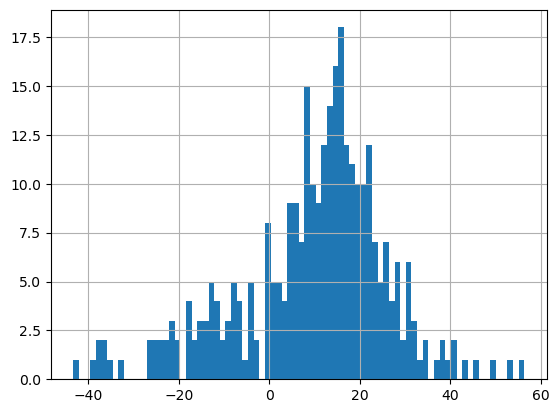

In [52]:
df[target].hist(bins=80)

In [53]:
df.shape

(314, 25)

In [54]:
y_classificated = np.where(y>increase, 1, 0)

In [55]:
y_classificated

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [56]:
# Split the targets into training/testing sets
y_classificated_train = y_classificated[:-days_for_test]
y_classificated_test = y_classificated[-days_for_test:]

In [57]:
index_test = df[['date', target]][-days_for_test:].index
index_test

Index([56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39,
       38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21,
       20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9],
      dtype='int64')

# Linear regression

In [58]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [59]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression()

In [60]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [61]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
r_sqr_test = r2_score(y_test, y_pred)
print("R^2: %.2f" % r_sqr_test)

Coefficients: 
 [-2.01502695  4.22769491 -0.15168173  0.0560306   7.60318412 -5.52851596
  2.05685674]
MSE: 703.47
R^2: -1.23


In [62]:
regression_result = pd.DataFrame([features, list(regr.coef_)]).T
regression_result.columns = ['Feature','Coefficient']
regression_result.set_index('Feature')

,Coefficient
Feature,
PE_RATIO,-2.015027
Fut_PE_Ratio,4.227695
5Y GENERIC,-0.151682
PE Yield,0.056031
Fwd PE Yield,7.603184
àéðôìöéä 1Y éãåòä,-5.528516
Net_liquidity_RSI,2.056857


## Linear regression with p-value

In [63]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     13.86
Date:                Mon, 09 Sep 2024   Prob (F-statistic):           3.18e-15
Time:                        18:18:55   Log-Likelihood:                -1075.0
No. Observations:                 266   AIC:                             2166.
Df Residuals:                     258   BIC:                             2195.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.5639     39.858     -1.444      0.150    -136.052      20.924
x1            -2.0150      2.030     -0.992      0.322      -6.013       1.983
x2             4.2277      2.528      1.673      0.096      -0.750       9.205
x3            -0.1517      0.853     -0.178      0.859      -1.831       1.527
x4             0.0560      7.363      0.008      0.994     -14.444      14.556
x5             7.6032      5.572      1.364      0.174      -3.370      18.576
x6            -5.5285      0.841     -6.572      0.000      -7.185      -3.872
x7             2.0569      6.470      0.318      0.751     -10.684      14.798
==============================================================================
Omnibus:                       14.826   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.668
Skew:                          -0.565   Prob(JB):                     0.000396
Kurtosis:                       3.371   Cond. No.                     1.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/s7/8_j4bgj967g5l_x97vbsfvwr0000gn/T/ipykernel_5989/619441070.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=1.0)


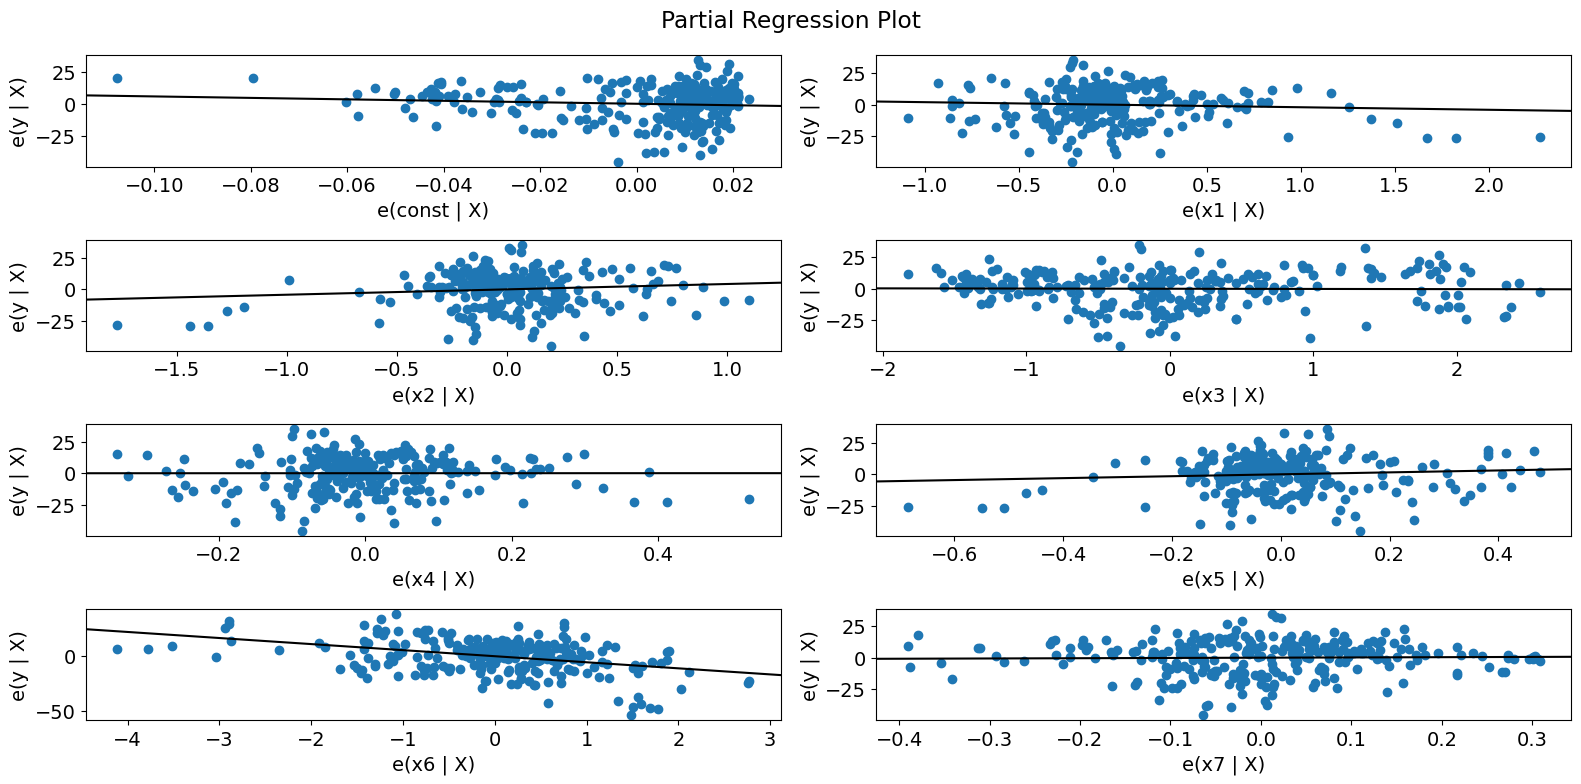

In [64]:
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(est2)
fig.tight_layout(pad=1.0)

* The R^2 of train

In [65]:
y_trained = regr.predict(X_train)
y_trained
r_sqr_train = r2_score(y_train, y_trained)
print("R^2: %.2f" % r_sqr_train)

R^2: 0.27


that means the model is not flexible enough

# Desision tree

In [66]:
clf = tree.DecisionTreeClassifier(random_state=4, max_depth=4, min_samples_leaf=2)
clf = clf.fit(X_train, y_classificated_train)

[Text(0.6125, 0.9, 'x[0] <= 22.457\ngini = 0.341\nsamples = 266\nvalue = [58, 208]'),
 Text(0.375, 0.7, 'x[5] <= 3.85\ngini = 0.226\nsamples = 208\nvalue = [27, 181]'),
 Text(0.2, 0.5, 'x[2] <= 4.167\ngini = 0.154\nsamples = 190\nvalue = [16, 174]'),
 Text(0.1, 0.3, 'x[1] <= 17.805\ngini = 0.07\nsamples = 164\nvalue = [6, 158]'),
 Text(0.05, 0.1, 'gini = 0.06\nsamples = 162\nvalue = [5, 157]'),
 Text(0.15, 0.1, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.3, 0.3, 'x[4] <= 6.756\ngini = 0.473\nsamples = 26\nvalue = [10, 16]'),
 Text(0.25, 0.1, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.35, 0.1, 'gini = 0.499\nsamples = 19\nvalue = [10, 9]'),
 Text(0.55, 0.5, 'x[2] <= 3.814\ngini = 0.475\nsamples = 18\nvalue = [11, 7]'),
 Text(0.5, 0.3, 'x[4] <= 8.647\ngini = 0.153\nsamples = 12\nvalue = [11, 1]'),
 Text(0.45, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.55, 0.1, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 6\nvalue = [0

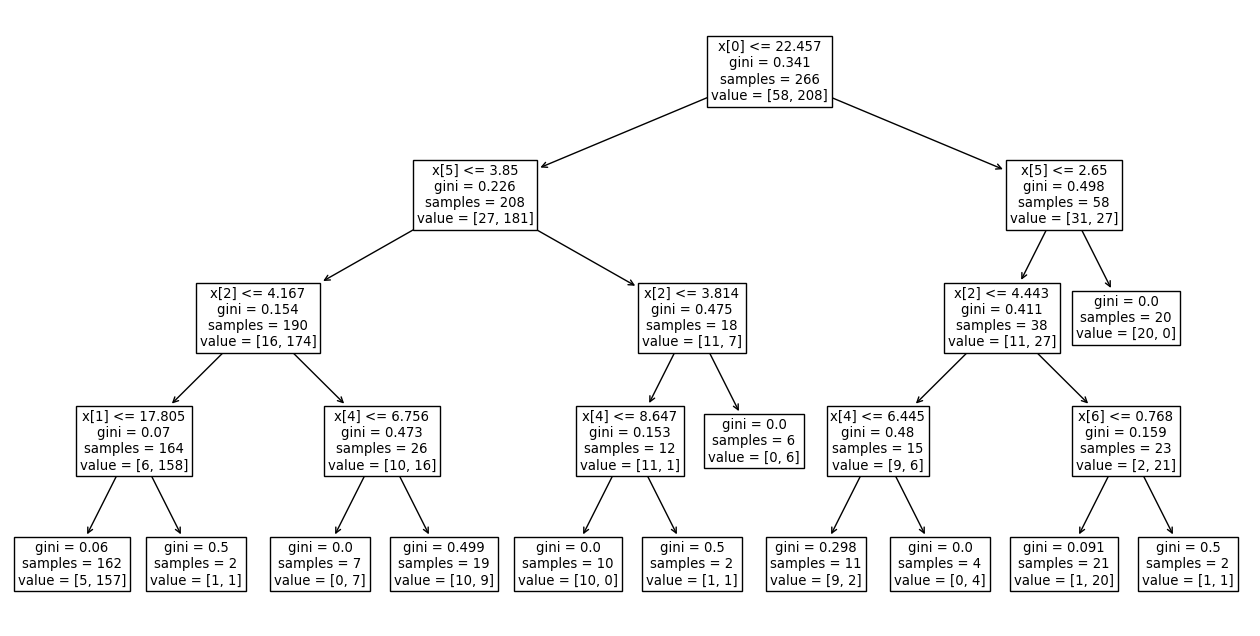

In [67]:
tree.plot_tree(clf)

In [68]:
from sklearn.tree import export_text

In [69]:
r = export_text(clf, feature_names=features)
print(r)

|--- PE_RATIO <= 22.46
|   |--- àéðôìöéä 1Y éãåòä <= 3.85
|   |   |--- 5Y GENERIC <= 4.17
|   |   |   |--- Fut_PE_Ratio <= 17.80
|   |   |   |   |--- class: 1
|   |   |   |--- Fut_PE_Ratio >  17.80
|   |   |   |   |--- class: 0
|   |   |--- 5Y GENERIC >  4.17
|   |   |   |--- Fwd PE Yield <= 6.76
|   |   |   |   |--- class: 1
|   |   |   |--- Fwd PE Yield >  6.76
|   |   |   |   |--- class: 0
|   |--- àéðôìöéä 1Y éãåòä >  3.85
|   |   |--- 5Y GENERIC <= 3.81
|   |   |   |--- Fwd PE Yield <= 8.65
|   |   |   |   |--- class: 0
|   |   |   |--- Fwd PE Yield >  8.65
|   |   |   |   |--- class: 0
|   |   |--- 5Y GENERIC >  3.81
|   |   |   |--- class: 1
|--- PE_RATIO >  22.46
|   |--- àéðôìöéä 1Y éãåòä <= 2.65
|   |   |--- 5Y GENERIC <= 4.44
|   |   |   |--- Fwd PE Yield <= 6.45
|   |   |   |   |--- class: 0
|   |   |   |--- Fwd PE Yield >  6.45
|   |   |   |   |--- class: 1
|   |   |--- 5Y GENERIC >  4.44
|   |   |   |--- Net_liquidity_RSI <= 0.77
|   |   |   |   |--- class: 1
|   |   |   

* ON TRAIN

In [70]:
y_t = clf.predict(X_train)
precision_rf = metrics.precision_score(y_classificated_train, y_t, average=None).round(2)
recall_rf = metrics.recall_score(y_classificated_train, y_t, average=None).round(2)

In [71]:
precision_rf

array([0.79, 0.97])

In [72]:
recall_rf

array([0.9 , 0.93])

* ON TEST

In [73]:
y_pred = clf.predict(X_test)

In [74]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_classificated_test, y_pred))

Accuracy: 0.4791666666666667


In [75]:
precision_tree = metrics.precision_score(y_classificated_test, y_pred, average=None)
print("Precision:", precision_tree)

Precision: [0.30555556 1.        ]


In [76]:
recall_tree = metrics.recall_score(y_classificated_test, y_pred, average=None)
print("Recall:", recall_tree)

Recall: [1.         0.32432432]


In [77]:
y_classificated_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [78]:
y_pred

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1])

In [79]:
def concat_test(y_classificated_test, y_pred, index, days_for_test, y, df):
    classed = pd.DataFrame(y_classificated_test, index=index, columns=['Classified'])
    pred = pd.DataFrame(y_pred, index=index, columns=['Predicted'])
    sp = pd.DataFrame(y[-days_for_test:], index=index, columns=['SP500 one year forward'])
    dates = df[-days_for_test:][['date']]
    return pd.concat([dates,sp, classed, pred], axis=1)

In [80]:
concat_test(y_classificated_test, y_pred, index_test, days_for_test, y, df)

,date,SP500 one year forward,Classified,Predicted
56,2019-09-30,15.148978,1,1
55,2019-10-31,9.710640,1,1
54,2019-11-29,17.456410,1,1
53,2019-12-31,18.398827,1,0
52,2020-01-31,17.249428,1,1
51,2020-02-28,31.290161,1,1
50,2020-03-31,56.351628,1,1
49,2020-04-30,45.981954,1,0
48,2020-05-29,40.318507,1,0
47,2020-06-30,40.794153,1,0


### This month

In [81]:
y_pred_this_month = clf.predict(X_this_month)
y_pred_this_month

array([0])

In [82]:
y_pred_this_year = clf.predict(X_this_year)
y_pred_this_year

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

### Viz the tree

In [83]:
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = features,class_names=['3','4','5'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('diabetes.png')
# Image(graph.create_png())

### Grid search for the tree

In [84]:
# hyperparameter tuning
def grid_search():
    param_grid = {
        'max_depth': [2,3,4],
        'min_samples_leaf': [3 , 8 ,10],
        'class_weight': [
                         {0: 3, 1:1},
                         {0: 2, 1:3},
                         {0: 7, 1:5}
                        ]
    }
    
    clf = tree.DecisionTreeClassifier(random_state=5)
    search = RandomizedSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=3)
    search.fit(X_train,y_classificated_train)

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

In [85]:
start = time.time()

grid_search()

end = time.time()
# print('execution time in minutes: ', (end - start)/60) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameter (CV score=0.689):
{'min_samples_leaf': 8, 'max_depth': 2, 'class_weight': {0: 7, 1: 5}}


In [86]:
clf = tree.DecisionTreeClassifier(random_state=4, max_depth=2, min_samples_leaf=8, class_weight={0: 7, 1: 3})
clf.fit(X_train,y_classificated_train)
y_pred = clf.predict(X_test)
precision_tree = metrics.precision_score(y_classificated_test, y_pred, average=None)
recall_tree = metrics.recall_score(y_classificated_test, y_pred, average=None)
print("Accuracy:",metrics.accuracy_score(y_classificated_test, y_pred))

Accuracy: 0.625


In [87]:
print("Accuracy:",metrics.accuracy_score(y_classificated_test, y_pred))

Accuracy: 0.625


In [88]:
precision_tree

array([0.37931034, 1.        ])

In [89]:
recall_tree

array([1.        , 0.51351351])

In [90]:
y_pred = clf.predict(X_test)

In [91]:
y_classificated_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [92]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [93]:
y_pred_this_year = clf.predict(X_this_year)
y_pred_this_year

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [94]:
concat_test(y_classificated_test, y_pred, index_test, days_for_test, y, df)

,date,SP500 one year forward,Classified,Predicted
56,2019-09-30,15.148978,1,1
55,2019-10-31,9.710640,1,1
54,2019-11-29,17.456410,1,1
53,2019-12-31,18.398827,1,1
52,2020-01-31,17.249428,1,1
51,2020-02-28,31.290161,1,1
50,2020-03-31,56.351628,1,1
49,2020-04-30,45.981954,1,1
48,2020-05-29,40.318507,1,1
47,2020-06-30,40.794153,1,1


# RandomForestClassifier

In [95]:
pipline = Pipeline(steps=[
    ('model', RandomForestClassifier())
])

Possible scorings: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [96]:
# hyperparameter tuning
def grid_search():
    param_grid = {
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf,
        'model__bootstrap': bootstrap
    }
    global search
    global scoring
    scoring = 'f1_macro'
    # scoring = 'recall'
    # scoring = 'precision'
    search = RandomizedSearchCV(pipline, param_grid, cv=5, n_jobs=-1, verbose=3, scoring=scoring)
    search.fit(X_train,y_classificated_train)

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

In [97]:
start = time.time()

grid_search()

end = time.time()
print('execution time in minutes: ', (end - start)/60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameter (CV score=0.446):
{'model__n_estimators': 247, 'model__min_samples_split': 8, 'model__min_samples_leaf': 6, 'model__max_features': 'sqrt', 'model__max_depth': 2, 'model__bootstrap': False}
execution time in minutes:  0.005762020746866862


/Users/kiril/anaconda3/envs/NTC_main/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kiril/anaconda3/envs/NTC_main/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kiril/anaconda3/envs/NTC_main/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/kiril/anaconda3/envs/NTC_main/lib/python3.9/site-packages/sklearn/pipeline.py", line 427

In [98]:
optimal_parameters = search.best_params_.copy()
optimal_parameters = pd.DataFrame([optimal_parameters])
optimal_parameters

,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__bootstrap
0,247,8,6,sqrt,2,False


In [99]:
rf = RandomForestClassifier(n_estimators=optimal_parameters['model__n_estimators'][0],
                            min_samples_split=optimal_parameters['model__min_samples_split'][0],
                            min_samples_leaf=optimal_parameters['model__min_samples_leaf'][0],
                            max_features=optimal_parameters['model__max_features'][0],
                            max_depth=optimal_parameters['model__max_depth'][0],
                            bootstrap=optimal_parameters['model__bootstrap'][0])
rf.fit(X_train,y_classificated_train)

RandomForestClassifier(bootstrap=False, max_depth=2, min_samples_leaf=6,
                       min_samples_split=8, n_estimators=247)

* ON TRAIN

In [100]:
y_t = rf.predict(X_train)
precision_rf = metrics.precision_score(y_classificated_train, y_t, average=None).round(2)
recall_rf = metrics.recall_score(y_classificated_train, y_t, average=None).round(2)

In [101]:
precision_rf

array([1.  , 0.85])

In [102]:
recall_rf

array([0.34, 1.  ])

* ON TEST

In [103]:
y_pred = rf.predict(X_test)
precision_rf = metrics.precision_score(y_classificated_test, y_pred, average=None).round(2)
recall_rf = metrics.recall_score(y_classificated_test, y_pred, average=None).round(2)

In [104]:
print("Accuracy:",metrics.accuracy_score(y_classificated_test, y_pred))

Accuracy: 0.9791666666666666


In [105]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [106]:
y_classificated_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [107]:
precision_rf

array([0.92, 1.  ])

In [108]:
recall_rf

array([1.  , 0.97])

## Get feature importances

In [109]:
feature_importances = rf.feature_importances_

# Sort features by importance
sorted_idx = feature_importances.argsort()[::-1]

# Print feature importance ranking
print("Feature ranking:")
for i, idx in enumerate(sorted_idx):
    print(f"{i + 1}. {features[idx]}: {int(round(feature_importances[idx],2)*100)}%")

Feature ranking:
1. àéðôìöéä 1Y éãåòä: 23%
2. PE Yield: 22%
3. PE_RATIO: 20%
4. 5Y GENERIC: 19%
5. Net_liquidity_RSI: 8%
6. Fut_PE_Ratio: 5%
7. Fwd PE Yield: 4%


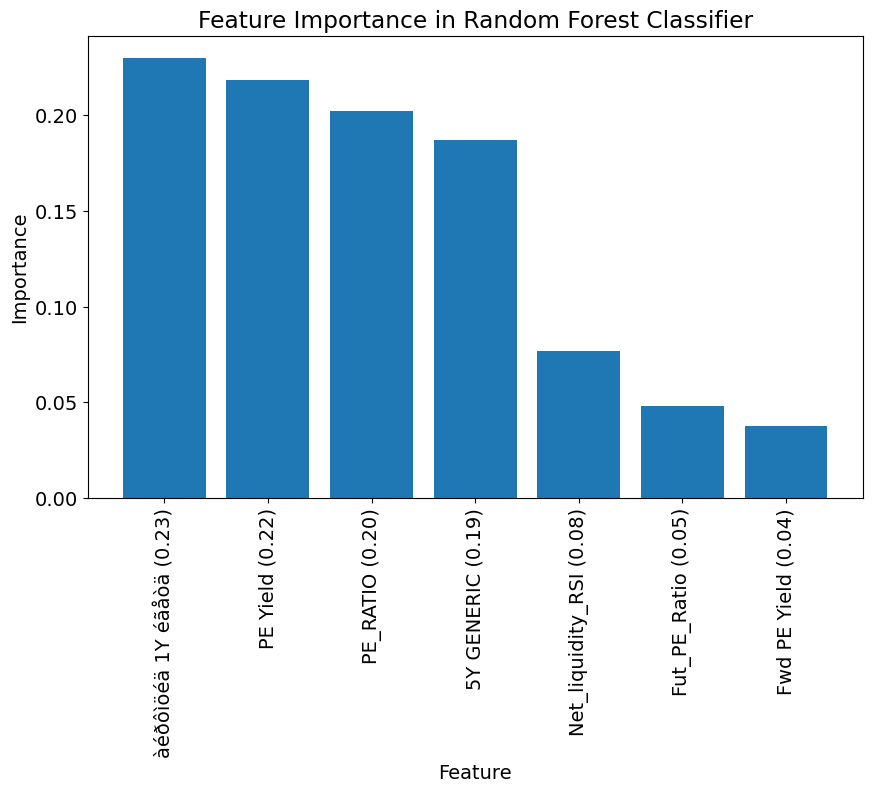

In [110]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X.shape[1]), [f"{features[i]} ({feature_importances[i]:.2f})" for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Classifier")
plt.show()

## This month

In [111]:
y_pred_this_month = rf.predict(X_this_month)
y_pred_this_month

array([0])

In [112]:
y_pred_this_year = rf.predict(X_this_year)
y_pred_this_year

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [113]:
concat_test(y_classificated_test, y_pred, index_test, days_for_test, y, df)

,date,SP500 one year forward,Classified,Predicted
56,2019-09-30,15.148978,1,1
55,2019-10-31,9.710640,1,1
54,2019-11-29,17.456410,1,1
53,2019-12-31,18.398827,1,1
52,2020-01-31,17.249428,1,1
51,2020-02-28,31.290161,1,1
50,2020-03-31,56.351628,1,1
49,2020-04-30,45.981954,1,1
48,2020-05-29,40.318507,1,1
47,2020-06-30,40.794153,1,1


###  Save Results

In [114]:
# rf_results = search.best_params_.copy()
# rf_results.update({'days for test' : days_for_test,
#                    'Regression R^2 of train' : r_sqr_train,
#                    'Regression R^2 of test' : r_sqr_test,
#                    'Tree_precision' : precision_tree,
#                    'Tree_recall' : recall_tree,
#                     'Forest_Scoring' : scoring,
#                     'Forest_Precision' : precision_rf,
#                    'Forest_Recall' : recall_rf,
#                     'Forest_Target' : target,
#                     'Range' : (increase),
#                      'Forest_y_pred' : y_pred,
#                      'Forest_y_test' : y_classificated_test,
#                        'features' : features,
#                       'A forecast for the next year' : y_pred_this_month})

In [115]:
# current_rf_results = pd.DataFrame([rf_results])
# current_rf_results

In [116]:
# only one time
# current_rf_results.to_csv('rf_results.csv', index= False)

In [117]:
# past_rf_results = pd.read_csv("rf_results.csv")
# past_rf_results

In [118]:
# pd.concat([past_rf_results, current_rf_results], ignore_index=True).to_csv("./rf_results.csv", index= False)

In [119]:
# pd.read_csv("rf_results.csv")

# XGBOOST

### model

In [120]:
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [121]:
# Train the model
model.fit(X_train, y_classificated_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

* ON TRAIN

In [122]:
y_t = model.predict(X_train)
precision_rf = metrics.precision_score(y_classificated_train, y_t, average=None).round(2)
recall_rf = metrics.recall_score(y_classificated_train, y_t, average=None).round(2)

In [123]:
precision_rf

array([1., 1.])

In [124]:
recall_rf

array([1., 1.])

* ON TEST

In [125]:
# Make predictions on the test set
y_pred = model.predict(X_test,)

In [126]:
# Calculate accuracy
accuracy = metrics.accuracy_score(y_classificated_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.60


In [127]:
precision_xgb = metrics.precision_score(y_classificated_test, y_pred, average=None)
recall_xgb = metrics.recall_score(y_classificated_test, y_pred, average=None)

In [128]:
precision_xgb

array([0.36666667, 1.        ])

In [129]:
recall_xgb

array([1.        , 0.48648649])

In [130]:
y_classificated_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [131]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0])

In [132]:
concat_test(y_classificated_test, y_pred, index_test, days_for_test, y, df)

,date,SP500 one year forward,Classified,Predicted
56,2019-09-30,15.148978,1,1
55,2019-10-31,9.710640,1,1
54,2019-11-29,17.456410,1,1
53,2019-12-31,18.398827,1,1
52,2020-01-31,17.249428,1,1
51,2020-02-28,31.290161,1,1
50,2020-03-31,56.351628,1,1
49,2020-04-30,45.981954,1,1
48,2020-05-29,40.318507,1,1
47,2020-06-30,40.794153,1,1


#### This month

In [133]:
y_pred_this_month = model.predict(X_this_month)
y_pred_this_month

array([0])

In [134]:
y_pred_this_year = model.predict(X_this_year)
y_pred_this_year

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

### Grid search

In [135]:
from sklearn.model_selection import GridSearchCV
# Create an XGBoost classifier with grid search for hyperparameter tuning
model_grid = xgb.XGBClassifier(objective='binary:logistic', min_child_weight=0.001, random_state=41)

# Define hyperparameters for fine-tuning with broader ranges
param_grid = {
    'learning_rate': np.logspace(-3, 0, 4),  # Range from 0.001 to 1
    'max_depth': np.arange(3, 6, 1),  # Range from 3 to 7
    'n_estimators': np.arange(40, 160, 40),  # Range from 10 to 160
    'subsample': np.arange(0, 1.1, 0.3),  # Range from 0 to 1.0
    'colsample_bytree': np.arange(0, 1.1, 0.3)  # Range from 0 to 1.0
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model_grid, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_classificated_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_classificated_test, y_pred)
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"F1 Score: {f1:.2f}")

Best Hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 120, 'subsample': 0.3}
F1 Score: 0.87


In [136]:
# Calculate accuracy
accuracy = metrics.accuracy_score(y_classificated_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.77


In [137]:
precision_xgb_grid = metrics.precision_score(y_classificated_test, y_pred, average=None)
recall_xgb_grid = metrics.recall_score(y_classificated_test, y_pred, average=None)

/Users/kiril/anaconda3/envs/NTC_main/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [138]:
precision_xgb_grid

array([0.        , 0.77083333])

In [139]:
recall_xgb_grid

array([0., 1.])

In [140]:
y_classificated_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [141]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

#### This month

In [142]:
y_pred_this_month = best_model.predict(X_this_month)
y_pred_this_month

array([1])

In [143]:
y_pred_this_year = best_model.predict(X_this_year)
y_pred_this_year

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [144]:
concat_test(y_classificated_test, y_pred, index_test, days_for_test, y, df)

,date,SP500 one year forward,Classified,Predicted
56,2019-09-30,15.148978,1,1
55,2019-10-31,9.710640,1,1
54,2019-11-29,17.456410,1,1
53,2019-12-31,18.398827,1,1
52,2020-01-31,17.249428,1,1
51,2020-02-28,31.290161,1,1
50,2020-03-31,56.351628,1,1
49,2020-04-30,45.981954,1,1
48,2020-05-29,40.318507,1,1
47,2020-06-30,40.794153,1,1
